In [ ]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install imblearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#plt.sytle.use('ggplot')

# read in data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [2]:
# explore data
print(train_data.head())
print(train_data.shape)
print(train_data['label'].value_counts())

   Unnamed: 0  label                                               text
0           0      4  dr. goldberg offers everything i look for in a...
1           1      1  Unfortunately, the frustration of being Dr. Go...
2           2      3  Been going to Dr. Goldberg for over 10 years. ...
3           3      3  Got a letter in the mail last week that said D...
4           4      0  I don't know what Dr. Goldberg was like before...
(650000, 3)
label
4    130000
1    130000
3    130000
0    130000
2    130000
Name: count, dtype: int64


### Labeled Review Chart
 The chart below shows uniform distribution of sentiment analysis and class balance, showing that the model will not be more biased towared more common classes.

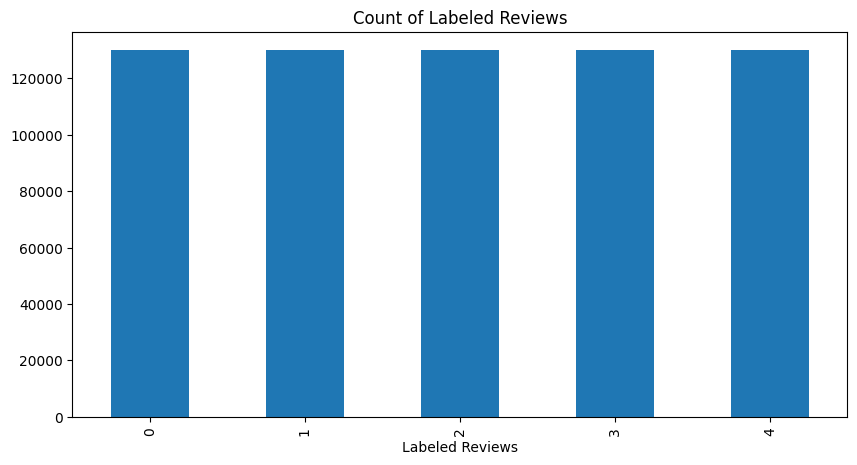

In [3]:
# Quick EDA
ax = train_data['label'].value_counts().sort_index().plot(kind='bar', title="Count of Labeled Reviews", figsize=(10, 5))
ax.set_xlabel("Labeled Reviews")
plt.show()

In [4]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

def preprocess_text_1(text):
    '''
    this function removes punctuation, converts text to lowercase, removes stopwords, and returns the cleaned text
    in the form of a string
    '''
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

train_data['text'] = train_data['text'].apply(preprocess_text_1)
test_data['text'] = test_data['text'].apply(preprocess_text_1)


[nltk_data] Downloading package stopwords to /Users/tay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


next, we will convert text to numerical representations

why?
- most ML algorithms will be working with numerical data as input so the machine can understand the data and use it for the algorithm
- this conversion is called feature extraction or vectorization

why are we using TF-IDF below?
- Term Frequency-Inverse Document Frequency is a popular method for converting text into numerical vectors. it assigns weights to each word based on how important or relevant it is in the corpus. words that appear frequently in a specific document (text review) but infrequently across the entire corpus are given higher weights, as they are more informative for that specific document.
- TF-IDF is widely used because it captures the relative importance of words in a doc., which can be beneficial for tasks like sentiment analysis, where the presence of certain words can strongly indicate the sentiment.

what are other models we could use, and would it be smart to test out using different methods?
- i want to compare these different text vectorization methods
    1. bag-of-words : simple method, counts the occurrences of each word in a document, representing it as a vector of word frequencies
    2. word embeddings : method represents words as dense vectors that capture semantic and syntactic info, such as Word2Vec or GloVe embeddings.
    3. n-gram models : instead of considering single words, n-grams capture sequences of n consecutive words, which can provide more context.

In [5]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

'''this converts text into TF-IDF vectors, which are used as features for the model'''
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['text'])
X_test = vectorizer.transform(test_data['text'])
y_train = train_data['label']
y_test = test_data['label']

# Validation Set
we want to separate the data into a validation set to tune hyperparameters and evaluate model's performance during training. this validation set acts as an unbiased proxy for the test set, allowing you to tune the model's hyperparmaters (regularization strength, number of trees, etc.) and prevent overfitting to the training data.

In [6]:
# lets separate the training data into a validation set
from sklearn.model_selection import train_test_split
# we use random_state to ensure reproducibility - it controls the randomness of the split. 42 is a common value
# you guarantee that the output of Run 1 will be equal to the output of Run 2, i.e. your split will be always the same
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Visualizing the Preprocessed Data
to get a better understanding of what it looks like before moving on

In [7]:
print('first 5 examples from training data')
#print(X_train[:5])
print(train_data[['text', 'label']].head())
print()
print(f'shape of training data: {X_train.shape}')
print(f'shape of validation data: {X_val.shape}')
print(f'shape of test data: {X_test.shape}')
print()
print('lbel distribution in training data')
print(train_data['label'].value_counts())
print('label distribution in test data')
print(test_data['label'].value_counts())
print()
print('example vectors from training data:')
print(X_train[:3])
'''
print the first 3 examples. each sample is represented as a vector with columns.
X_train is the vectorized text data, each row represents on text sample (review) and each column represents a feature (word in the TF-IDF vector)
[:3] is the slicing which selects the first 3 samples
the multiple lines for each sample is that the vectors are high dimension and python prints them on on multiple lines for readability
'''

first 5 examples from training data
                                                text  label
0  dr goldberg offers everything look general pra...      4
1  unfortunately frustration dr goldbergs patient...      1
2  going dr goldberg years think one st patients ...      3
3  got letter mail last week said dr goldberg mov...      3
4  dont know dr goldberg like moving arizona let ...      0

shape of training data: (520000, 790337)
shape of validation data: (130000, 790337)
shape of test data: (50000, 790337)

lbel distribution in training data
label
4    130000
1    130000
3    130000
0    130000
2    130000
Name: count, dtype: int64
label distribution in test data
label
0    10000
2    10000
1    10000
3    10000
4    10000
Name: count, dtype: int64

example vectors from training data:
  (0, 14481)	0.3521445436384422
  (0, 520172)	0.22519277351182185
  (0, 506118)	0.21425344076291708
  (0, 438206)	0.17074109239568955
  (0, 747013)	0.1685015538587805
  (0, 358168)	0.3609007648115094

'\nprint the first 3 examples. each sample is represented as a vector with columns.\nX_train is the vectorized text data, each row represents on text sample (review) and each column represents a feature (word in the TF-IDF vector)\n[:3] is the slicing which selects the first 3 samples\nthe multiple lines for each sample is that the vectors are high dimension and python prints them on on multiple lines for readability\n'

# Decision Tree Classifer

In [9]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Evaluate Model Performance

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

predictions = dt_model.predict(X_val)
print(accuracy_score(y_val, predictions))
print(classification_report(y_val, predictions))

0.3887307692307692
              precision    recall  f1-score   support

           0       0.53      0.53      0.53     26100
           1       0.31      0.31      0.31     25992
           2       0.31      0.31      0.31     26130
           3       0.32      0.32      0.32     26048
           4       0.46      0.47      0.47     25730

    accuracy                           0.39    130000
   macro avg       0.39      0.39      0.39    130000
weighted avg       0.39      0.39      0.39    130000



# Results Analysis
The performance shows similar results across each class, which means this is balanced and the model is not biased towards any class. This could mean, however, that the model can't really distinguish between the classes. The overall accuracy is about 38.87%.

## Model Complexity
Reasons for this could be model complexity.  If the tree is too complex, it could be overfitting. Pruning the tree would help here. To prune the tree we could limit the depth or set a minimum samples per leaf. If the tree is too simple, it's not capturing necessary patterns in data. To ensure more patterns are captured, we could increase the depth.

## Feature Engineering
We could try to use better features that could capture the sentiment more effectively:
- N-grams : use bi-grams or tri-grams to capture context
- Word Embeddings: use pre-trained embeddings like Word2Vec, GloVe, or BERT embeddings 

## Hyperparameter Tuning
We can try using a systematic search for the best hyperparameters using grid search or random search 
- Grid Search : test randge of values for parameters: 'max_depth', 'min_samples_split', and 'min_samples_leaf'
- Random Search : sample wider range of values. typically this is more efficient than grid search

## Other Things To Try:
- Remove stop words
- use stemming or lemmatization, which reduce words to their root form
    - use nltk.stem.WordNetLemmatizer
- Instead of removing all characters except letters, include punctuation like '?' or '!' which can express sentiment
- Tweak the parameters of the TF-IDF like 'ngram_range', 'max_df', 'min_df', and 'max_features'

# Implementation of Decision Tree Take 2

In [2]:
import nltk
import re
import pandas as pd
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# reload original data
# TODO: could read in once and every time I apply a preprocessing function, name the variable after which preprocessing function was applied
# that way I can keep track of the data at each stage of preprocessing and just load the original data once
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

def preprocess_text_2(text):
    '''
    this function removes all non-alphabetic characters and leaves only words. 
    it then coverts all text to lowercase for consistency and splits the text into words.
    it then lemmatizes the words to their root form.
    then it joins the words back together into a single string and returns the cleaned text
    '''
    text = re.sub(r'[\d\W]+', ' ', text)
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text]

    return ' '.join(text)

train_data['text'] = train_data['text'].apply(preprocess_text_2)
test_data['text'] = test_data['text'].apply(preprocess_text_2)

[nltk_data] Downloading package wordnet to /Users/tay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# TF-IDF Vectorization with bigrams and feature selection
# TF-IDF takes text data and converts it into a high dimensional vector representation
# set up to use uni-grams and bi-grams, remove words that appear in more than 95% of the documents, 
#    remove words that appear in less than 5 documents, and limit the number of features to 5000
# these 5000 dimensions are the "top" features as determined by the TF-IDF vectorizer
print("Starting TF-IDF Vectorization...")
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.95, min_df=5, max_features=5000)
X_train = vectorizer.fit_transform(train_data['text'])
X_test = vectorizer.transform(test_data['text'])
print("Completed TF-IDF Vectorization.")

# Dimensionality Reduction
# do this reduce the feature space which can help the model generalize better. this is making the model less complex
# so we are further reducing the dimnesionality of the data from 5000 to 1000 while trying to preserve as much information as possible
from sklearn.decomposition import IncrementalPCA

print("Starting Dimensionality Reduction with IncrementalPCA...")
n_batches = 100  # or another number that fits your memory constraints
ipca = IncrementalPCA(n_components=100, batch_size=n_batches)
X_train_ipca = ipca.fit_transform(X_train)
print(f"Explained variance ratio: {ipca.explained_variance_ratio_.sum()}")
X_test_ipca = ipca.transform(X_test)
print("Completed Dimensionality Reduction.")

# Splitting the data into training and validation sets with stratification
print("Splitting the data into training and validation sets...")
X_train_ipca, X_val_ipca, y_train, y_val = train_test_split(X_train_ipca, train_data['label'], test_size=0.2, random_state=42, stratify=train_data['label'])
print("Completed splitting.")

# Hyperparameter tuning
print("Starting Hyperparameter Tuning with GridSearchCV...")
dt_params = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(random_state=42)
clf = GridSearchCV(dt, dt_params, cv=3, scoring='accuracy', n_jobs=7)
clf.fit(X_train_ipca, y_train)
print("Completed Hyperparameter Tuning.")

print("Evaluating the best model...")
best_dt_model = clf.best_estimator_
predictions = best_dt_model.predict(X_val_ipca)
print(f"Accuracy: {accuracy_score(y_val, predictions)}")
print(classification_report(y_val, predictions))

print("Refitting the best model on the entire dataset...")
best_dt_model.fit(X_train_ipca, y_train)
print("Completed refitting.")

Starting TF-IDF Vectorization...
Completed TF-IDF Vectorization.
Starting Dimensionality Reduction with IncrementalPCA...
Explained variance ratio: 0.18481176299725932
Completed Dimensionality Reduction.
Splitting the data into training and validation sets...
Completed splitting.
Starting Hyperparameter Tuning with GridSearchCV...
Completed Hyperparameter Tuning.
Evaluating the best model...
Accuracy: 0.41823846153846156
              precision    recall  f1-score   support

           0       0.52      0.61      0.56     26000
           1       0.34      0.31      0.33     26000
           2       0.35      0.36      0.35     26000
           3       0.35      0.30      0.32     26000
           4       0.49      0.51      0.50     26000

    accuracy                           0.42    130000
   macro avg       0.41      0.42      0.41    130000
weighted avg       0.41      0.42      0.41    130000

Refitting the best model on the entire dataset...
Completed refitting.
